In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import random
from six.moves import urllib
import matplotlib.pyplot as plt

# Get Data

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/SamuelFriedlaender/ML_assignment/master/"
CAR_URL = DOWNLOAD_ROOT + "car_price_prediction.csv"

def fetch_ML_data(car_url=CAR_URL):
    # Download the CSV data directly into a Pandas DataFrame
    car_df = pd.read_csv(car_url)
    return car_df

df = fetch_ML_data()

# Set a seed for the random module
random.seed(42)

# ID, Levy

In [3]:
df = df.drop(columns = ["ID", "Levy"])

# Price

In [4]:
def get_outliers(df,features,thold):
    outlier_indices = []
    
    for c in features:
        # 1st quartile
        Q1 = np.percentile(df[c],25)
        # 3rd quartile
        Q3 = np.percentile(df[c],75)
        # IQR
        IQR = Q3 - Q1
        # Outlier step
        outlier_step = IQR * thold
        # Detect outlier and their indeces
        outlier_list_col = df[(df[c] < Q1 - outlier_step) | (df[c] > Q3 + outlier_step)].index
        # Store indeces
        outlier_indices.extend(outlier_list_col)
    
    
    return outlier_indices

outliers = get_outliers(df, ["Price"], 1.5)
df = df.drop(df.loc[outliers].index,axis=0)

#Set threshold of prices larger than 500 
df = df[df["Price"]>500]

# Manufacturer

In [5]:
## Manufacturer
#In order to be able to make good predictions we focus only on Manufacturers with at least 20 cars
manufacturer_counts = df['Manufacturer'].value_counts()
brands_to_keep = manufacturer_counts[manufacturer_counts >= 100].index
df = df[df['Manufacturer'].isin(brands_to_keep)]
#df = pd.concat([df, pd.get_dummies(df["Manufacturer"], dtype = int)], axis=1) #Converting to dummies

# Model

In [6]:
## Model
#There are hundreds of different models even for a given manufacturer,
#In order not to lose this information we group the models for each manuf. into three classes (top/mid/low) based on the avg. price of the model
df['Class'] = ''
unique_manufacturers = df['Manufacturer'].unique()

def model_class_dividion(df):

    # Group the DataFrame by the specified manufacturer
    #df_manufacturer = df[df['Manufacturer'] == manufacturer]

    # Calculate the average price for each model
    manufacturer_avg_price = df.groupby('Model')['Price'].mean()

    # Determine the price boundaries for low, mid, and top classes
    price_quantiles = manufacturer_avg_price.quantile([0, 1/7, 2/7, 3/7, 4/7, 5/7, 6/7, 1])
    price_quantiles = price_quantiles.reset_index(drop=True)

    # Iterate through the models and classify them
    for model, avg_price in manufacturer_avg_price.items():
        if avg_price < price_quantiles[1]:
            df.loc[df['Model'] == model, 'Class'] = 'Class_Lowest'
        elif avg_price < price_quantiles[2]:
            df.loc[df['Model'] == model, 'Class'] = 'Class_Low'
        elif avg_price < price_quantiles[3]:
            df.loc[df['Model'] == model, 'Class'] = 'Class_MidLow'
        elif avg_price < price_quantiles[4]:
            df.loc[df['Model'] == model, 'Class'] = 'Class_Mid'
        elif avg_price < price_quantiles[5]:
            df.loc[df['Model'] == model, 'Class'] = 'Class_MidHigh'
        elif avg_price < price_quantiles[6]:
            df.loc[df['Model'] == model, 'Class'] = 'Class_High'
        else:
            df.loc[df['Model'] == model, 'Class'] = 'Class_Highest'

    # Create three dummy variables for each class of car model
    df = pd.concat([df, pd.get_dummies(df['Class'], dtype = int)], axis=1) #Converting to dummies
    #df['Class'] = ''

    return df

#We group the models for all manufaturers
#for manuf in unique_manufacturers:
#    model_class_dividion(df, manuf)
model_class_dividion(df)
df = pd.concat([df, pd.get_dummies(df['Class'], dtype = int)], axis=1)
#We drop the columns we no longer need
df = df.drop(['Class', 'Model', 'Class_Mid'], axis=1)

# Production year, vategory, leather interior, fuel type, engine volume

In [7]:
## Prod. Year
df = df[df["Prod. year"]>=2000] #Taking cars produced from year 2000
## Category
#df = pd.concat([df, pd.get_dummies(df['Category'], dtype = int)], axis=1) #Converting to dummies
df = df.drop(columns = ["Category"])
## Leather interior
df['Leather interior'] = df['Leather interior'].map({'Yes': 1, 'No': 0})
## Fuel type
df = pd.concat([df, pd.get_dummies(df['Fuel type'], dtype = int)], axis=1) #Converting to dummies
df = df.drop(columns = ["Fuel type", 'Petrol'])
## Engine volume
def is_turbo(value):
    return 1 if 'turbo'in value.lower() else 0

df['turbo'] = df['Engine volume'].apply(is_turbo)

def clean_engine_volume(value):
    return float(value.split(" ")[0])

df['Engine volume'] = df['Engine volume'].apply(clean_engine_volume)
df = df.drop(['Engine volume'], axis=1)

# Mileage

In [8]:
## Mileage
df["Mileage"] = df["Mileage"].apply(lambda x: int(x[:-3]))
outliers = get_outliers(df, ["Mileage"], 1.5)
df = df.drop(df.loc[outliers].index,axis=0)

# Cylinders, gear box type, drive wheels

In [9]:
## Cylinders
#Nothing changes
## Gear box type
df = pd.concat([df, pd.get_dummies(df["Gear box type"], dtype = int)], axis=1) #Converting to dummies
df = df.drop(columns = ["Gear box type", 'Automatic'])
## Drive wheels

#df = pd.concat([df, pd.get_dummies(df["Drive wheels"], dtype = int)], axis=1) #Converting to dummies
df = df.drop(columns = ["Drive wheels"])

# Doors

In [10]:
## Doors
#def get_doors(value):
#    if value == "04-May":
#        return "4-5"
#    elif value == "02-Mar":
#        return "2-3"
#    else:
#        return ">5"
#df["Doors"] = df["Doors"].apply(get_doors)
#df = pd.concat([df, pd.get_dummies(df["Doors"], dtype = int)], axis=1) #Converting to dummies
df = df.drop(columns = ["Doors"])

# Wheel, color

In [11]:
## Wheel
def get_wheel(value):
    if value == "Left wheel":
        return "Left wheel"
    elif value == "Right-hand drive":
        return "Right wheel"

df["Wheel"] = df["Wheel"].apply(get_wheel)

df = pd.concat([df, pd.get_dummies(df["Wheel"], dtype = int)], axis=1) #Converting to dummies
df = df.drop(columns = ["Wheel", 'Left wheel'])
## Color

# Group the data by the "Color" column and calculate the average price
grouped_data = df.groupby('Color')['Price'].mean().reset_index()
grouped_data.rename(columns={'Price': 'Average_Price'}, inplace=True)

# Define your price thresholds
expensive_threshold = grouped_data['Average_Price'].quantile(2/3)
medium_expensive_threshold = grouped_data['Average_Price'].quantile(1/3)

# Function to categorize cars based on price
def categorize_price(row):
    if row['Average_Price'] > expensive_threshold:
        return 'Expensive_color'
    elif row['Average_Price'] > medium_expensive_threshold:
        return 'Medium expensive_color'
    else:
        return 'Inexpensive_color'

# Apply the categorization function to the grouped data
grouped_data['Price_Category'] = grouped_data.apply(categorize_price, axis=1)

# Merge the grouped data back into the original DataFrame using the 'Color' column
df = df.merge(grouped_data[['Color', 'Price_Category']], on='Color')

# Convert 'Price_Category' column to dummy variables
df = pd.get_dummies(df, columns=['Price_Category'], prefix='', prefix_sep='')

# Convert Boolean columns to integers (1 or 0)
for column in df.columns:
    if df[column].dtype == bool:
        df[column] = df[column].astype(int)
df = df.drop(['Color','Medium expensive_color'], axis=1)

# Airbags

In [12]:
## Airbags
#Not changing anything
## Finalization of data pre-processing
df = df.drop(['Manufacturer'], axis=1)
df.to_csv('final_data_car_price_prediction_manfucuters_dropped.csv', index=False)

In [13]:
#Check if there are any null values
df.isna().any()

Price                False
Prod. year           False
Leather interior     False
Mileage              False
Cylinders            False
Airbags              False
Class_High           False
Class_Highest        False
Class_Low            False
Class_Lowest         False
Class_MidHigh        False
Class_MidLow         False
CNG                  False
Diesel               False
Hybrid               False
Hydrogen             False
LPG                  False
Plug-in Hybrid       False
turbo                False
Manual               False
Tiptronic            False
Variator             False
Right wheel          False
Expensive_color      False
Inexpensive_color    False
dtype: bool

# Data scaling

In [14]:
#Data scaling by Min Max
scaler = MinMaxScaler()

df.loc[:, ["Mileage", "Cylinders", "Airbags"]] = scaler.fit_transform(df.loc[:, ["Mileage", "Cylinders", "Airbags"]])

# Correlation matrix

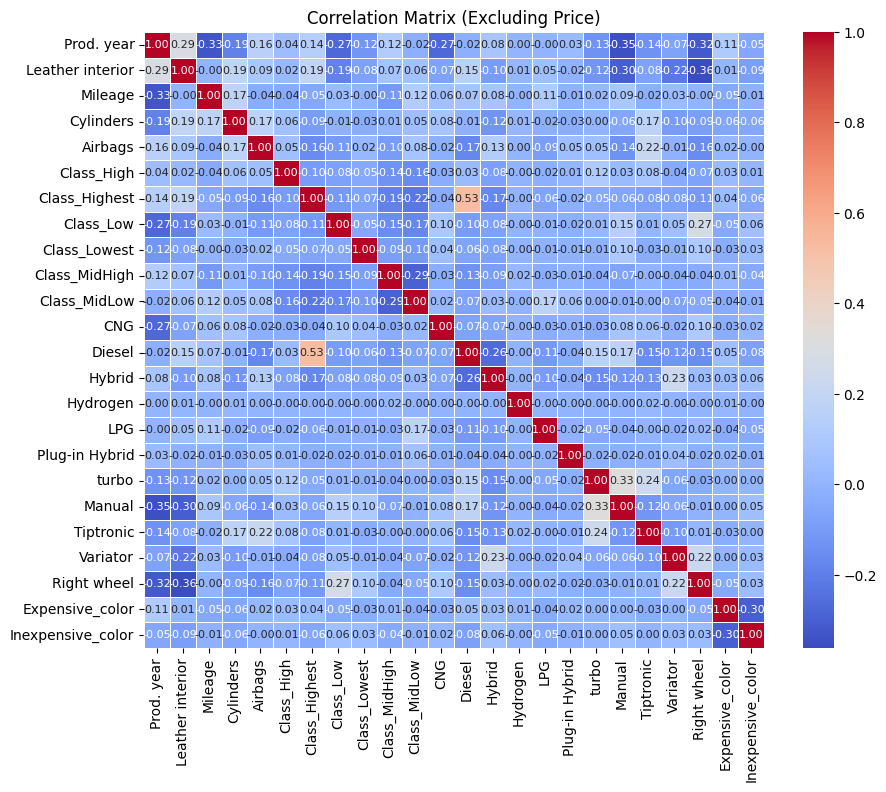

In [15]:
df_excluded_price = df.drop('Price', axis=1)
correlation_matrix = df_excluded_price.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, annot_kws={"size": 8})
plt.title('Correlation Matrix (Excluding Price)')
plt.show()

# Exporting the data

In [16]:
#Export the dataframe to the CSV
df.to_csv("preprocessed_data_ml.csv")